In [1]:
# packages

import numpy as np
import matplotlib as mpl
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import scipy

from scipy.signal import sawtooth, square, savgol_filter
import pandas as pd
import glob as gl
import os
import cmath

from scipy.signal import sawtooth, square,find_peaks, savgol_filter
from scipy import spatial
#import lambdafit as lf
from scipy.interpolate import CubicSpline,interp1d
import h5py

from tqdm import tqdm as tqdm_terminal
from tqdm.notebook import trange, tqdm_notebook
from scipy.signal.windows import hann

from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit


# for pandas visual number display 

pd.set_option('display.precision', 6)
pd.set_option('display.float_format', '{:.10f}'.format)

### Time Chunking for Beam-map data

In [2]:

#Functions for reading, processing, and demodulating real data
def read_data(filename, chunk='all', chunk_start=None, chunk_stop=None, single_channel=None):
    # read in file
    file = h5py.File(filename, 'r') 
    # pre-setting range for the for-loop iterating to fix the 0-22 rows of resonator buffer 
    buffer_range_fixed = range(22, (file['time_ordered_data']['adc_i'].shape[0])) 
    # iterate depending on chunk argument 
    if chunk == 'all':
        ch = np.array([channel - 22 for channel in buffer_range_fixed])
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed])
        adc_q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed])
        
    elif chunk == 'some': 
        ch = np.array([channel - 22 for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array([file['time_ordered_data']['adc_i'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        adc_q = np.array([file['time_ordered_data']['adc_q'][channel] for channel in buffer_range_fixed[chunk_start:chunk_stop]])
        
    elif chunk == 'single':
        ch = np.array(buffer_range_fixed[single_channel] - 22)
        t = np.array(file['time_ordered_data']['timestamp'])
        adc_i = np.array(file['time_ordered_data']['adc_i'][buffer_range_fixed[single_channel]])
        adc_q = np.array(file['time_ordered_data']['adc_q'][buffer_range_fixed[single_channel]])
                              
    return t, adc_i, adc_q, ch, file # this function will now have 4 outputs instead of 3

#### 1. Correct time segements from .txt (x,y) file

In [4]:
ts_f = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/ts_toneinit_fcenter_4250.0_20240308061355_t_20240308062147.hd5'
times_xy = '/home/matt/ali_drive_mnt/beam_map_data/toneinit_fcenter_4250.0_20240308061355_t_20240308062133/beam_map_data_20240308062147.txt'
t_xy = pd.read_csv(times_xy, sep=',') # beam map x,y time data raw (starts and ends need correction)
t_xy

,start,end,x,y
0,1709907709.2978785038,1709907959.6177837849,0,0
1,1709907961.6202144623,1709907965.1014409065,10,0
2,1709907967.1036620140,1709907970.5852940083,20,0
3,1709907972.5858492851,1709907976.0646548271,30,0
4,1709907978.0658402443,1709907981.5459232330,40,0
...,...,...,...,...
5771,1709939586.7333009243,1709939590.2120680809,40,750
5772,1709939592.2142755985,1709939595.6955122948,30,750
5773,1709939597.6966049671,1709939601.1780261993,20,750
5774,1709939603.1804363728,1709939606.6595745087,10,750


In [10]:
t_xy = t_xy.rename(columns={' end':'end'}) # there's a space before "end" in the column name, correct

In [15]:
#rearranging

# pull out arrays
start_1 = np.array(t_xy['start'])
stop_1 = np.array(t_xy['end'])
# delete first 
start_1_new = np.delete(start_1, 0)
start_1_new = np.pad(start_1_new, (0, 1)) # keep lengths the same, add zero at end (FOR NOW)
# confirm
print(start_1[0:3])
print(start_1_new[0:3])
print(start_1[1]==start_1_new[0])



[1.70990771e+09 1.70990796e+09 1.70990797e+09]
[1.70990796e+09 1.70990797e+09 1.70990797e+09]
True


One thing to note here: 
- the final time (end time of final measurement) is obviously not zero, and needs to be replaced... zero for now?
- okay actually no, just going to add average measurement timespan to final "start"

In [16]:
# set new columns (switch em)

start_new = stop_1
stop_new = start_1_new 

t_xy_new = t_xy.copy()
t_xy_new['start'] = start_new
t_xy_new['end'] = stop_new

print(t_xy, t_xy_new)


                     start                   end   x    y
0    1709907709.2978785038 1709907959.6177837849   0    0
1    1709907961.6202144623 1709907965.1014409065  10    0
2    1709907967.1036620140 1709907970.5852940083  20    0
3    1709907972.5858492851 1709907976.0646548271  30    0
4    1709907978.0658402443 1709907981.5459232330  40    0
...                    ...                   ...  ..  ...
5771 1709939586.7333009243 1709939590.2120680809  40  750
5772 1709939592.2142755985 1709939595.6955122948  30  750
5773 1709939597.6966049671 1709939601.1780261993  20  750
5774 1709939603.1804363728 1709939606.6595745087  10  750
5775 1709939608.6617915630 1709939612.1427226067   0  750

[5776 rows x 4 columns]                      start                   end   x    y
0    1709907959.6177837849 1709907961.6202144623   0    0
1    1709907965.1014409065 1709907967.1036620140  10    0
2    1709907970.5852940083 1709907972.5858492851  20    0
3    1709907976.0646548271 1709907978.065840244

In [17]:
for i in range(len(t_xy)):
    if t_xy_new['start'][i] != t_xy['end'][i]:
        print(False)


In [18]:
t_xy_new['end'][0]-t_xy_new['start'][0]

2.0024306774139404

In [19]:
times = np.hstack([t_xy_new['start'], t_xy_new['end']])
times

array([1.70990796e+09, 1.70990797e+09, 1.70990797e+09, ...,
       1.70993960e+09, 1.70993961e+09, 0.00000000e+00])

In [20]:
diffs = []

for i in range(len(t_xy_new)):
    diffs.append(t_xy_new['end'][i] - t_xy_new['start'][i])


In [21]:
print('average measurement time: ' + str(np.average(diffs[:-1])))
print('stdev of measurement time: ' + str(np.std(diffs[:-1])))
print('median measurement time: ' + str(np.median(diffs[:-1])))

average measurement time: 2.0021414247735754
stdev of measurement time: 0.00042056351601956295
median measurement time: 2.002235174179077


(array([  60.,   86.,   84.,  103.,  101.,  111.,  104.,  214., 3916.,
         996.]),
 array([2.00013256, 2.00038066, 2.00062876, 2.00087686, 2.00112495,
        2.00137305, 2.00162115, 2.00186925, 2.00211735, 2.00236545,
        2.00261354]),
 <BarContainer object of 10 artists>)

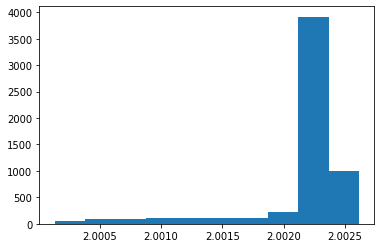

In [24]:
plt.hist(diffs[:-1])

In [25]:
orig_diffs = []

for i in range(len(t_xy)):
    orig_diffs.append(t_xy['end'][i] - t_xy['start'][i])


Was trying to verify the measurement times were correct. Going to go with the new dataframe for now but can always go back and change...

In [26]:
len(t_xy_new)

5776

#### 2. Read timestream data file

In [27]:
# for now, just going to separate them out, later on might be better to have it return a dictionary

t, i, q, ch, file = read_data(ts_f,chunk='some', chunk_start=10, chunk_stop=12)

In [28]:
# trying to find bias line to match up with my channel searching but can't find it... 
file['global_data'].keys()

<KeysViewHDF5 ['attenuator_settings', 'baseband_freqs', 'chan_number', 'chanmask', 'detector_beam_ampl', 'detector_delta_x', 'detector_delta_y', 'detector_dx_dy_elevation_angle', 'detector_pol', 'dfoverf_per_mK', 'ifslice_number', 'lo_freq', 'rfsoc_number', 'sample_rate', 'tile_number', 'tone_powers']>

In [30]:
# look at properties 
print(len(t), len(i), len(q), len(ch)) 

# last three will all be 2 because I grabbed two channels

15578912 2 2 2


In [35]:
# array of (t, i, q) for both channels
ch_10 = np.asarray((t, (i[0] + 1j*q[0])))
ch_11 = np.asarray((t, (i[1] + 1j*q[1]))) 

# check out time data for channel 10 (taken complex)
ch_10[0].real

array([1.70990771e+09, 1.70990771e+09, 1.70990771e+09, ...,
       1.70993961e+09, 1.70993961e+09, 1.70993961e+09])

In [36]:
ch_10[0].real

array([1.70990771e+09, 1.70990771e+09, 1.70990771e+09, ...,
       1.70993961e+09, 1.70993961e+09, 1.70993961e+09])

In [37]:
int(3*len(ch_10[0])/8)

5842092

In [38]:
# breaking into smaller time chunks, just in order to look at smaller bits?
ch10_tchunks = np.asarray(((ch_10[0:int(len(ch_10[0])/4), 0:int(len(ch_10[0])/4)]), 
                          (ch_10[int(len(ch_10[0])/4):int(len(ch_10[0])/2), int(len(ch_10[0])/4):int(len(ch_10[0])/2)]),
                          (ch_10[int(len(ch_10[0])/2):int(3*len(ch_10[0])/4), int(len(ch_10[0])/2):int(3*len(ch_10[0])/4)]),
                          (ch_10[int(3*(len(ch_10[0])/4)):int(len(ch_10[0])), int(3*(len(ch_10[0])/4)):int(len(ch_10[0]))])
                          ))

/tmp/ipykernel_1606450/3190745606.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ch10_tchunks = np.asarray(((ch_10[0:int(len(ch_10[0])/4), 0:int(len(ch_10[0])/4)]),


In [39]:
len(ch_10[0]) == len(ch10_tchunks[0][0])*4

True

In [40]:
print('time start stream: ' + str(t[0]))
print('time start mapper: ' + str(t_xy_new['start'].iloc[0]))

print('time end stream: ' + str(t[-1]))
print('time end mapper: ' + str(t_xy_new['end'].iloc[-2]))

time start stream: 1709907709.3054738
time start mapper: 1709907959.6177838
time end stream: 1709939614.9082284
time end mapper: 1709939608.6617916


In [41]:
%matplotlib qt

ch10_chunk1 = ch10_tchunks[0]

plt.plot(ch10_chunk1[0], ch10_chunk1[1])

/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [44]:
# working with the first quarter of the time stream 

t_chunk1 = ch10_chunk1[0].real
t_chunk1

array([1.70990771e+09, 1.70990771e+09, 1.70990771e+09, ...,
       1.70991569e+09, 1.70991569e+09, 1.70991569e+09])

In [45]:
t_chunk1[-1]

1709915685.7053478

In [46]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx



In [47]:
find_nearest_idx(t_xy_new['end'], t_chunk1[-1])

1409

In [48]:
plt.figure()
plt.plot(t_chunk1, ch10_chunk1[1], lw=0.3, label='timestream signal')
for i in range(0,1408):
    plt.axvspan(t_xy_new['start'][i], t_xy_new['end'][i], color='red', alpha=0.5)

plt.axvspan(t_xy_new['start'][1409], t_xy_new['end'][1409], color='red', alpha=0.5, label='measurement window')
plt.ylim(-1000, 5500)
plt.xlim(t_chunk1[200000], t_chunk1[220000])
plt.xlabel('timestamp (unix)')
plt.ylabel('I + jQ signal')
plt.legend()
plt.tight_layout()

/tmp/ipykernel_1606450/211290290.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


/home/matt/.local/readout/lib/python3.10/site-packages/ipykernel/eventloops.py:107: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.exec_()


In [49]:
# okay so now really trying to merge these two sets: 

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

What do I want?
1. grab the start and end time stamps from x,y times
2. find the index nearest to those in the timestream times
3. index the actual signal by those 

Note: there has to be a < > system so that no signal data is taken from when mapper is moving

In [57]:
# baby steps: just extract the times first

def get_timestream_chunk_idx(t_ts, t_xy_start, t_xy_end):

    t_ts = np.asarray(t_ts)

    start_range = t_ts[t_ts >= t_xy_start]
    end_range = t_ts[t_ts <= t_xy_end]

    ts_start_range_idx = (np.abs(start_range - t_xy_start)).argmin()
    ts_stop_range_idx = (np.abs(end_range - t_xy_end)).argmin()

    ts_start_idx = np.where(t_ts == start_range[ts_start_range_idx])[0][0]
    ts_end_idx = np.where(t_ts == end_range[ts_stop_range_idx])[0][0]

    return ts_start_idx, ts_end_idx 




In [53]:
# t: timestamps from timestream data
# t_xy_new: timestamps from mapper position .txt

ts_0, ts_1 = get_timestream_chunk_idx(t, t_xy_new['start'][4], t_xy_new['end'][4])

In [61]:
print('start, end indices result: ' + str([ts_0, ts_1]))
print('start, end mapper times: ' + str([t_xy_new['start'][4], t_xy_new['end'][4]]))
print('start, end times indexed from timestream: ' + str([t[ts_0], t[ts_1]]))

start, end indices result: [132933, 133909]
start, end mapper times: [1709907981.5459232, 1709907983.5482965]
start, end times indexed from timestream: [1709907981.5476093, 1709907983.5462747]


In [66]:
len(ch_10[0]) == len(ch_10[1])

True

Okay accomplished getting the indices closest between the two time arrays. 

Now: first rewrite the time chunk index function for retrieving all index points 

Then: grabbing the signal

In [72]:
# baby steps: just extract the times first

# operating on the pandas frame, can change later? 
# note: trying this out, need to input a much shorter table .... ?

def get_timestream_chunk_idx_ALL(t_ts, t_xy_table): # t_xy_starts, t_xy_ends):

    t_ts = np.asarray(t_ts)

    ts_idxs = []

    for i in range(len(t_xy_table)):

        t_xy_start = t_xy_table['start'][i]
        t_xy_end = t_xy_table['end'][i]

        start_range = t_ts[t_ts >= t_xy_start]
        end_range = t_ts[t_ts <= t_xy_end]

        ts_start_range_idx = (np.abs(start_range - t_xy_start)).argmin()
        ts_stop_range_idx = (np.abs(end_range - t_xy_end)).argmin()

        ts_start_idx = np.where(t_ts == start_range[ts_start_range_idx])[0][0]
        ts_end_idx = np.where(t_ts == end_range[ts_stop_range_idx])[0][0]

        ts_idxs.append([ts_start_idx, ts_end_idx])

    return ts_idxs

In [76]:
# testing

idxs_test = get_timestream_chunk_idx_ALL(t, t_xy_new.iloc[0:11])

In [77]:
idxs_test

[[122226, 123202],
 [124903, 125880],
 [127581, 128557],
 [130256, 131233],
 [132933, 133909],
 [135610, 136586],
 [138285, 139262],
 [140961, 141938],
 [143637, 144613],
 [146312, 147289],
 [148988, 149964]]

In [81]:
print([t[0], t[-1]])
print([t[idxs_test][0][0], t[idxs_test][0][1]])

[1709907709.3054738, 1709939614.9082284]
[1709907959.61947, 1709907961.6183698]


In [78]:
len(t)

15578912

In [98]:
plt.figure(figsize = (10,8))
plt.plot(t[122220:149964], ch_10[1, 122220:149964], lw=0.2, label='timestream signal')

for i in range(0,11):
    plt.axvspan(t_xy_new['start'][i], t_xy_new['end'][i], color='red', alpha=0.5)
    plt.axvline(t[idxs_test[i][0]], color = 'blue')
    plt.axvline(t[idxs_test[i][1]], color = 'purple')


plt.axvspan(t_xy_new['start'][10], t_xy_new['end'][10], color='red', alpha=0.5, label='measurement window')
plt.axvline(t[idxs_test[10][0]], color = 'blue', label = 'nearest timestream start')
plt.axvline(t[idxs_test[10][1]], color = 'purple', label = 'nearest timestream end')

plt.ylim(-1000, 5500)
plt.xlim(t[122200], t[133909])
plt.xlabel('timestamp (unix)')
plt.ylabel('I + jQ signal')
plt.legend(loc='upper right')
plt.tight_layout()

In [ ]:
# the ch_ts here is a combined (t, (I + jQ)) array

def get_time_chunked_signal(ch_ts, start_idx, end_idx): 

    for i in range(len(ch_ts[0])):

        